<p align="center">
  <img width="100" height="100" src="../images/logo.png">
</p>

<div>
<h1>03. Preproceso: Modelo C_SEV</h1> 

Canadian Car Accidents Practice <br>
<strong>Aprendizaje Automático</strong> <br>
<strong>Master Universitario en Ciencia de Datos<strong>
</div>

<div style='text-align:right'>Álvaro Serrano del Rincón (<i>a.serranodelrincon@cunef.edu</i>)</div>
<div style='text-align:right'>Carlos Viñals Guitart (<i>carlos.vinals@cunef.edu</i>)</div>

---

## 3.0 Introducción

En este notebook realizaremos el preprocesado de los datos del dataset conforme al análisis realizado en el notebook EDA 
```01_EDA```. Para ello procederemos a explicar paso a paso las decisiones tomadas en cuanto a su preprocesado.

Para este trabajo estamos utilizando un entorno de propósito espécifico.

In [1]:
# Verificamos el entorno: ML_P1
!conda info


     active environment : ML_P1
    active env location : C:\Users\carviagu\anaconda3\envs\ML_P1
            shell level : 2
       user config file : C:\Users\carviagu\.condarc
 populated config files : 
          conda version : 4.10.3
    conda-build version : 3.21.4
         python version : 3.8.8.final.0
       virtual packages : __cuda=11.3=0
                          __win=0=0
                          __archspec=1=x86_64
       base environment : C:\Users\carviagu\anaconda3  (writable)
      conda av data dir : C:\Users\carviagu\anaconda3\etc\conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/win-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/win-64
                          https://repo.anaconda.com/pkgs/r/noarch
                          https://repo.anaconda.com/pkgs/msys2/win-64
                          https://repo.anaconda.com/pkgs/msys2/no

### 3.0.1 Estructura

<< PONER ESTRUCTURA >>

## Librerías

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px

%matplotlib inline

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

## Scripts
En este notebook procedemos a importar dos scripts con funciones útiles, previamente utilizadas en el EDA y que permitirán verificar el proceso de realización de las muestras de train y test.

In [3]:
import sys

import sys  
sys.path.insert(0, '../scripts/')

import csv_tools
import eda_tools

## 3.1 Lectura y preparación

A continuación leeremos el dataset, de la misma forma que lo hicimos en el EDA.

In [4]:
# Función propia que verifica que existe el fichero de datos previamente.
accidents_df = csv_tools.csv_import(origin="../data/sev_df.csv")

Reading file...
Reading ended.


In [5]:
accidents_df.head()

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,C_PERS
0,1999,01,1,night,2,01,object,normal,normal,dragged,normal,unsafe,1
1,1999,01,1,night,2,01,object,normal,normal,dragged,normal,unsafe,1
2,1999,01,1,night,2,01,object,normal,bad,normal,normal,unsafe,1
3,1999,01,1,night,2,01,object,normal,bad,dragged,curve/ramp,unsafe,2
4,1999,01,1,night,2,01,object,UU,normal,normal,curve/ramp,unsafe,1


## 3.2 Train y Test
A continuación vamos a proceder a crear y dividir los datos en Train (muestra de entrenamiento) y test (muestra de test) que usaremos para nuestros modelos. 

In [6]:
# Separamos los valores (X) de la variable objetivo (Y)
X = accidents_df.drop('C_SEV', axis=1)
Y = accidents_df['C_SEV']

# Realizamos la división de train y test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=1234)

## 3.3 Balanceo de la variable objetivo en Train
En el EDA pudimos apreciar como había un importante desequilibrio en la variable objetivo, existiendo un 98% y 2% de accidentes no mortales y mortales respectivamente. 

In [7]:
X_train_sev = pd.concat([X_train, Y_train], axis=1)
eda_tools.classes_overview(df = X_train_sev, obj_val = 'C_SEV')

,index,percentaje,C_SEV
0,2,98.05434,1404952
1,1,1.94566,27878


Para que nuestro modelo entrene de la forma más adecuada vamos a realizar un balanceo de la variable objetivo en Train. Este no se realiza en test pues no nos importa su composición de la variable objetivo al no utilizarse como muestra de entrenamiento del modelo.

Para ello realizaremos un remuestreo de los datos mediante la técnica de **subsampling** con el objetivo de reducir el número de muestras de la clase 2 (ningún fallecido) frente a las de 1 (al menos un fallecido). Para ello:
* Primero, dividimos el dataset dos dataset, uno por clase.
* Segundo, realizamos un resample de la clase mayoritaria, para extraer una muestra del mismo. 
* Finalmente, juntaremos ambos datasets para formar la muestra a utilizar. 

In [8]:
# Dividimos la clases
sev01_df = X_train_sev[X_train_sev['C_SEV'] == 1]
sev02_df = X_train_sev[X_train_sev['C_SEV'] == 2]

Realizamos una muestra de ```sev02_df``` con un tamaño superior al 15% de ```sev01_df```. Esto se realiza para que pese a reducir el desequilibrio existente, buscamos que se asemeje a la realidad y por lo tanto mantenga cierto grado de desequilibrio. 

Destacar que usamos como semilla el valor 0. Este se ha determinado de forma arbitraria, permitirá replicar los resultados en caso de querer realizar más pruebas.

In [9]:
# Tamaño a muestrear
sample_size = int(sev01_df.shape[0] * (1.20))

# Realizamos una muestra del sev02_df
sev02_sam_df = resample(sev02_df, replace=True, n_samples = sample_size, random_state=0)

# Juntamos y creamos la versión a utilizar
X_train_sev = pd.concat([sev01_df, sev02_sam_df])
X_train_sev['C_SEV'].value_counts()

2    33453
1    27878
Name: C_SEV, dtype: int64

Observamos como se ha reducido considerablemente la muestra de accidentes no mortales, y hemos podido equilibrar en cierto grado el dataset. 

In [10]:
Y_train = X_train_sev['C_SEV']
X_train = X_train_sev.drop(['C_SEV'], axis=1)

## 3.4 Tratamiento
A continuación procederemos a realizar la limpieza de los datos y su procesamiento:

Analizamos tipos:

In [11]:
eda_tools.dataset_overview(data = X_train)

,columna,tipo_dato,nulos,nulos%
0,C_YEAR,int64,0,0.0
1,C_MNTH,object,0,0.0
2,C_WDAY,object,0,0.0
3,C_HOUR,object,0,0.0
4,C_VEHS,object,0,0.0
5,C_CONF,object,0,0.0
6,C_RCFG,object,0,0.0
7,C_WTHR,object,0,0.0
8,C_RSUR,object,0,0.0
9,C_RALN,object,0,0.0


### 3.4.2 Valores faltantes
Para llevar a cabo este proceso realizaremos la conversión correspondiente por tipo de variable, esto es, pues el signficado que estas tienen es distinto. 

A nivel general si el porcentaje es inferior a 0.1 dedicidimos eliminar esas variables, en caso contrario aplicaremos una técnicas de sustitución de ese valor. Consideramos que un valor inferior a 0.1 no es relevante para los datos.

Primero veamos como está la muestra de train:

In [12]:
especial_values = [['U', 'UU', 'UUUU'], ['Q', 'QQ', 'QQQQ']]

# Valoración del train
eda_tools.special_values_summary(df = X_train, vals = especial_values)

,column_name,U,U%,Q,Q%,total,total%
0,C_YEAR,0,[0.0],0,[0.0],0,0.0
1,C_MNTH,4,[0.007],0,[0.0],4,0.0
2,C_WDAY,14,[0.023],0,[0.0],14,0.0
3,C_HOUR,878,[1.432],0,[0.0],878,1.4
4,C_VEHS,5,[0.008],0,[0.0],5,0.0
5,C_CONF,1843,[3.005],3406,[5.553],5249,8.6
6,C_RCFG,5174,[8.436],2080,[3.391],7254,11.8
7,C_WTHR,897,[1.463],177,[0.289],1074,1.8
8,C_RSUR,769,[1.254],2147,[3.501],2916,4.8
9,C_RALN,3725,[6.074],304,[0.496],4029,6.6


In [13]:
# Valoración del test
eda_tools.special_values_summary(df = X_test, vals = especial_values)

,column_name,U,U%,Q,Q%,total,total%
0,C_YEAR,0,[0.0],0,[0.0],0,0.0
1,C_MNTH,17,[0.005],0,[0.0],17,0.0
2,C_WDAY,98,[0.027],0,[0.0],98,0.0
3,C_HOUR,4499,[1.256],0,[0.0],4499,1.3
4,C_VEHS,37,[0.01],0,[0.0],37,0.0
5,C_CONF,13273,[3.705],21247,[5.931],34520,9.6
6,C_RCFG,35380,[9.877],12102,[3.378],47482,13.3
7,C_WTHR,6719,[1.876],1108,[0.309],7827,2.2
8,C_RSUR,5837,[1.63],12655,[3.533],18492,5.2
9,C_RALN,29326,[8.187],2203,[0.615],31529,8.8


**Para los valores U (desconocido)**: Se establecerá el valor medio ponderado (redondeado a la unidad superior) de las categorías asignadas. Al haber tanta variabilidad asignaremos la categoría media.

**Para los valores Q (otra categoría no contemplada)**: Se eliminarán del dataset pues no poseen información útil de cara a determinar la mortalidad.

Es importante tener en cuenta aspectos de la variable que estemos hablando, lo vemos  a continuación:

```C_MNTH```: Observamos valores ```U```, estos son inferiores a un 0.1% lo que los hace insignificantes dentro y por lo tanto los eliminamos.

In [14]:
# Train
to_drop = X_train[X_train['C_MNTH'] == 'UU'].index
X_train = X_train.drop(to_drop, axis=0)
Y_train = Y_train.drop(to_drop, axis=0)

# Test
to_drop = X_test[X_test['C_MNTH'] == 'UU'].index
X_test = X_test.drop(to_drop, axis=0)
Y_test = Y_test.drop(to_drop, axis=0)

```C_WDAY```: Observamos valores ```U```, estos son inferiores a un 0.1% lo que los hace insignificantes dentro y por lo tanto los eliminamos.

In [15]:
# Train
to_drop = X_train[X_train['C_WDAY'] == 'U'].index
X_train = X_train.drop(to_drop, axis=0)
Y_train = Y_train.drop(to_drop, axis=0)

# Test
to_drop = X_test[X_test['C_WDAY'] == 'U'].index
X_test = X_test.drop(to_drop, axis=0)
Y_test = Y_test.drop(to_drop, axis=0)

```C_HOUR```: Observamos que hay valores ```U```. Hacemos uso de una tabla resumen que muestra el porcentaje de valores por categoría y la variable objetivo mayoritaria de esa categoría.

In [16]:
XY_train = X_train.copy()
XY_train['C_SEV'] = Y_train
eda_tools.classes_overview_target(df = XY_train, target = 'C_SEV', obj_val = 'C_HOUR')

,index,percentaje,C_HOUR,C_SEV
0,afternoon,36.697816,22502,2
1,morning,31.431740,19273,2
2,night,30.446695,18669,1
3,UU,1.423749,873,1


Categorizaremos los valores ```UU``` como accidentes nocturnos (```night```), pues es la variable mayoritaria con su misma variable objetivo.

In [17]:
X_train['C_HOUR'] = X_train['C_HOUR'].replace(to_replace = 'UU', value = 'night')
X_test['C_HOUR'] = X_test['C_HOUR'].replace(to_replace = 'UU', value = 'night')

```C_VEHS```: Observamos valores ```U```, estos son inferiores a un 0.1% lo que los hace insignificantes dentro y por lo tanto los eliminamos.

In [18]:
# Train
to_drop = X_train[X_train['C_VEHS'] == 'UU'].index
X_train = X_train.drop(to_drop, axis=0)
Y_train = Y_train.drop(to_drop, axis=0)

# Test
to_drop = X_test[X_test['C_VEHS'] == 'UU'].index
X_test = X_test.drop(to_drop, axis=0)
Y_test = Y_test.drop(to_drop, axis=0)

```C_CONF```: Tiene valores ```U``` y ```Q```. Los valores ```Q``` por su naturaleza se asignan a la categoría ```other```, mientras que los valores ```U``` se categorizarán como ```back```, pues es el mayoritario con su misma variable objetivo.

In [19]:
XY_train = X_train.copy()
XY_train['C_SEV'] = Y_train
eda_tools.classes_overview_target(df = XY_train, target = 'C_SEV', obj_val = 'C_CONF')

,index,percentaje,C_CONF,C_SEV
0,other,20.279549,12434,1
1,roll,16.415768,10065,1
2,back,14.313441,8776,2
3,angle,11.416828,7000,1
4,front,10.082690,6182,2
5,object,7.220328,4427,2
6,turn,6.261315,3839,1
7,QQ,5.553472,3405,2
8,side,3.787125,2322,2
9,UU,3.004257,1842,2


In [20]:
# Valores QQ se engloban dentro de la categoría other
X_train['C_CONF'] = X_train['C_CONF'].replace(to_replace = 'QQ', value = 'other')
X_test['C_CONF'] = X_test['C_CONF'].replace(to_replace = 'QQ', value = 'other')

# Valores UU se traspasan a la categoría de back
X_train['C_CONF'] = X_train['C_CONF'].replace(to_replace = 'UU', value = 'back')
X_test['C_CONF'] = X_test['C_CONF'].replace(to_replace = 'UU', value = 'back')

```C_RCFG```: Tiene valores ```U``` y ```Q```. Los valores ```Q``` por su naturaleza se asignan a la categoría ```specific```, los valores ```U``` se categorizarán como ```specific``` también, pues coincide en variable objetivo. 

In [21]:
XY_train = X_train.copy()
XY_train['C_SEV'] = Y_train
eda_tools.classes_overview_target(df = XY_train, target = 'C_SEV', obj_val = 'C_RCFG')

,index,percentaje,C_RCFG,C_SEV
0,normal,47.968620,29411,2
1,specific,40.206808,24652,1
2,UU,8.433774,5171,1
3,QQ,3.390798,2079,2


In [22]:
# Valores QQ se engloban dentro de la categoría specific, no pueden ser normales
X_train['C_RCFG'] = X_train['C_RCFG'].replace(to_replace = 'QQ', value = 'specific')
X_test['C_RCFG'] = X_test['C_RCFG'].replace(to_replace = 'QQ', value = 'specific')

# Valores UU se traspasan a la categoría de specific, misma C_SEV
X_train['C_RCFG'] = X_train['C_RCFG'].replace(to_replace = 'UU', value = 'specific')
X_test['C_RCFG'] = X_test['C_RCFG'].replace(to_replace = 'UU', value = 'specific')

```C_WTHR```: Tiene valores ```U``` y ```Q```. Los valores ```Q``` por su naturaleza se asignan a la categoría ```bad```, asumimos que son condiciones poco habituales. En el caso de los valores ```U``` al no existir una coincidencia de variable objetivo asumimos que son condiciones normales y se clasificán como ```normal```.

In [23]:
XY_train = X_train.copy()
XY_train['C_SEV'] = Y_train
eda_tools.classes_overview_target(df = XY_train, target = 'C_SEV', obj_val = 'C_WTHR')

,index,percentaje,C_WTHR,C_SEV
0,normal,75.218958,46119,1
1,bad,23.031005,14121,1
2,U,1.461354,896,2
3,Q,0.288683,177,1


In [24]:
# Valores QQ se engloban dentro de la categoría bad, asumimos que son condiciones poco habituales
X_train['C_WTHR'] = X_train['C_WTHR'].replace(to_replace = 'Q', value = 'bad')
X_test['C_WTHR'] = X_test['C_WTHR'].replace(to_replace = 'Q', value = 'bad')

# Valores UU se traspasan a la categoría de normal, variable mayoritaria (sin coincidencias de CSEV)
X_train['C_WTHR'] = X_train['C_WTHR'].replace(to_replace = 'U', value = 'normal')
X_test['C_WTHR'] = X_test['C_WTHR'].replace(to_replace = 'U', value = 'normal')

```C_RSUR```: 

In [25]:
XY_train = X_train.copy()
XY_train['C_SEV'] = Y_train
eda_tools.classes_overview_target(df = XY_train, target = 'C_SEV', obj_val = 'C_RSUR')

,index,percentaje,C_RSUR,C_SEV
0,normal,81.096994,49723,1
1,dragged,14.150343,8676,2
2,Q,3.500073,2146,2
3,U,1.252589,768,2


In [26]:
# Valores Q se engloban dentro de la categoría dragged, no pueden ser normales
X_train['C_RSUR'] = X_train['C_RSUR'].replace(to_replace = 'Q', value = 'dragged')
X_test['C_RSUR'] = X_test['C_RSUR'].replace(to_replace = 'Q', value = 'dragged')

# Valores U se traspasan a la categoría de dragged, misma C_SEV
X_train['C_RSUR'] = X_train['C_RSUR'].replace(to_replace = 'U', value = 'dragged')
X_test['C_RSUR'] = X_test['C_RSUR'].replace(to_replace = 'U', value = 'dragged')

```C_RALN```

In [27]:
XY_train = X_train.copy()
XY_train['C_SEV'] = Y_train
eda_tools.classes_overview_target(df = XY_train, target = 'C_SEV', obj_val = 'C_RALN')

,index,percentaje,C_RALN,C_SEV
0,normal,60.752206,37249,2
1,curve/ramp,32.679856,20037,1
2,U,6.073753,3724,2
3,Q,0.494186,303,2


In [28]:
# Valores Q se engloban dentro de la categoría curve/ramp, no pueden ser normales
X_train['C_RALN'] = X_train['C_RALN'].replace(to_replace = 'Q', value = 'curve/ramp')
X_test['C_RALN'] = X_test['C_RALN'].replace(to_replace = 'Q', value = 'curve/ramp')

# Valores U se traspasan a la categoría normal, misma C_SEV
X_train['C_RALN'] = X_train['C_RALN'].replace(to_replace = 'U', value = 'normal')
X_test['C_RALN'] = X_test['C_RALN'].replace(to_replace = 'U', value = 'normal')

```C_TRAF```

In [29]:
XY_train = X_train.copy()
XY_train['C_SEV'] = Y_train
eda_tools.classes_overview_target(df = XY_train, target = 'C_SEV', obj_val = 'C_TRAF')

,index,percentaje,C_TRAF,C_SEV
0,unsafe,65.782134,40333,2
1,safe,28.212614,17298,1
2,UU,4.294358,2633,2
3,QQ,1.710893,1049,2


In [30]:
# Valores Q se engloban dentro de la categoría safe, otro tipo de medida de seguridad no contemplada
X_train['C_TRAF'] = X_train['C_TRAF'].replace(to_replace = 'QQ', value = 'safe')
X_test['C_TRAF'] = X_test['C_TRAF'].replace(to_replace = 'QQ', value = 'safe')

# Valores U se traspasan a la categoría unsafe, misma C_SEV
X_train['C_TRAF'] = X_train['C_TRAF'].replace(to_replace = 'UU', value = 'unsafe')
X_test['C_TRAF'] = X_test['C_TRAF'].replace(to_replace = 'UU', value = 'unsafe')

Verificamos que todo es correcto:

In [31]:
eda_tools.special_values_summary(df = X_train, vals = especial_values)

,column_name,U,U%,Q,Q%,total,total%
0,C_YEAR,0,[0.0],0,[0.0],0,0.0
1,C_MNTH,0,[0.0],0,[0.0],0,0.0
2,C_WDAY,0,[0.0],0,[0.0],0,0.0
3,C_HOUR,0,[0.0],0,[0.0],0,0.0
4,C_VEHS,0,[0.0],0,[0.0],0,0.0
5,C_CONF,0,[0.0],0,[0.0],0,0.0
6,C_RCFG,0,[0.0],0,[0.0],0,0.0
7,C_WTHR,0,[0.0],0,[0.0],0,0.0
8,C_RSUR,0,[0.0],0,[0.0],0,0.0
9,C_RALN,0,[0.0],0,[0.0],0,0.0


In [32]:
eda_tools.special_values_summary(df = X_test, vals = especial_values)

,column_name,U,U%,Q,Q%,total,total%
0,C_YEAR,0,[0.0],0,[0.0],0,0.0
1,C_MNTH,0,[0.0],0,[0.0],0,0.0
2,C_WDAY,0,[0.0],0,[0.0],0,0.0
3,C_HOUR,0,[0.0],0,[0.0],0,0.0
4,C_VEHS,0,[0.0],0,[0.0],0,0.0
5,C_CONF,0,[0.0],0,[0.0],0,0.0
6,C_RCFG,0,[0.0],0,[0.0],0,0.0
7,C_WTHR,0,[0.0],0,[0.0],0,0.0
8,C_RSUR,0,[0.0],0,[0.0],0,0.0
9,C_RALN,0,[0.0],0,[0.0],0,0.0


Hemos tratado todos los valores especiales y ahora nuestro conjunto de datos no posee valores missings.

### 3.4.3 Codificación de variables y tipos
Ahora que hemos tratado los valores missings y especiales procedermos a modificar los tipos y codificaciones de las variables

#### 3.4.3.1 Variables numéricas
Para este modelo consideramos variables numéricas: 
* ```C_YEAR```: Año del accidente
* ```C_VEHS```: Número de vehículos implicados
* ```C_PERS```: Número de personas implicadas

Solo ```C_PERS``` es ya de tipo numérico. Convertimos las otras dos:

In [35]:
numeric = ['C_YEAR', 'C_VEHS', 'C_PERS']
for col in numeric:
    X_train[col] = X_train[col].astype(float)
    X_test[col] = X_test[col].astype(float)

#### 3.4.3.2 Variables categóricas: Encoding

Vamos a codificar las variable categóricas. Repasemos primero la estructura de las categorías:

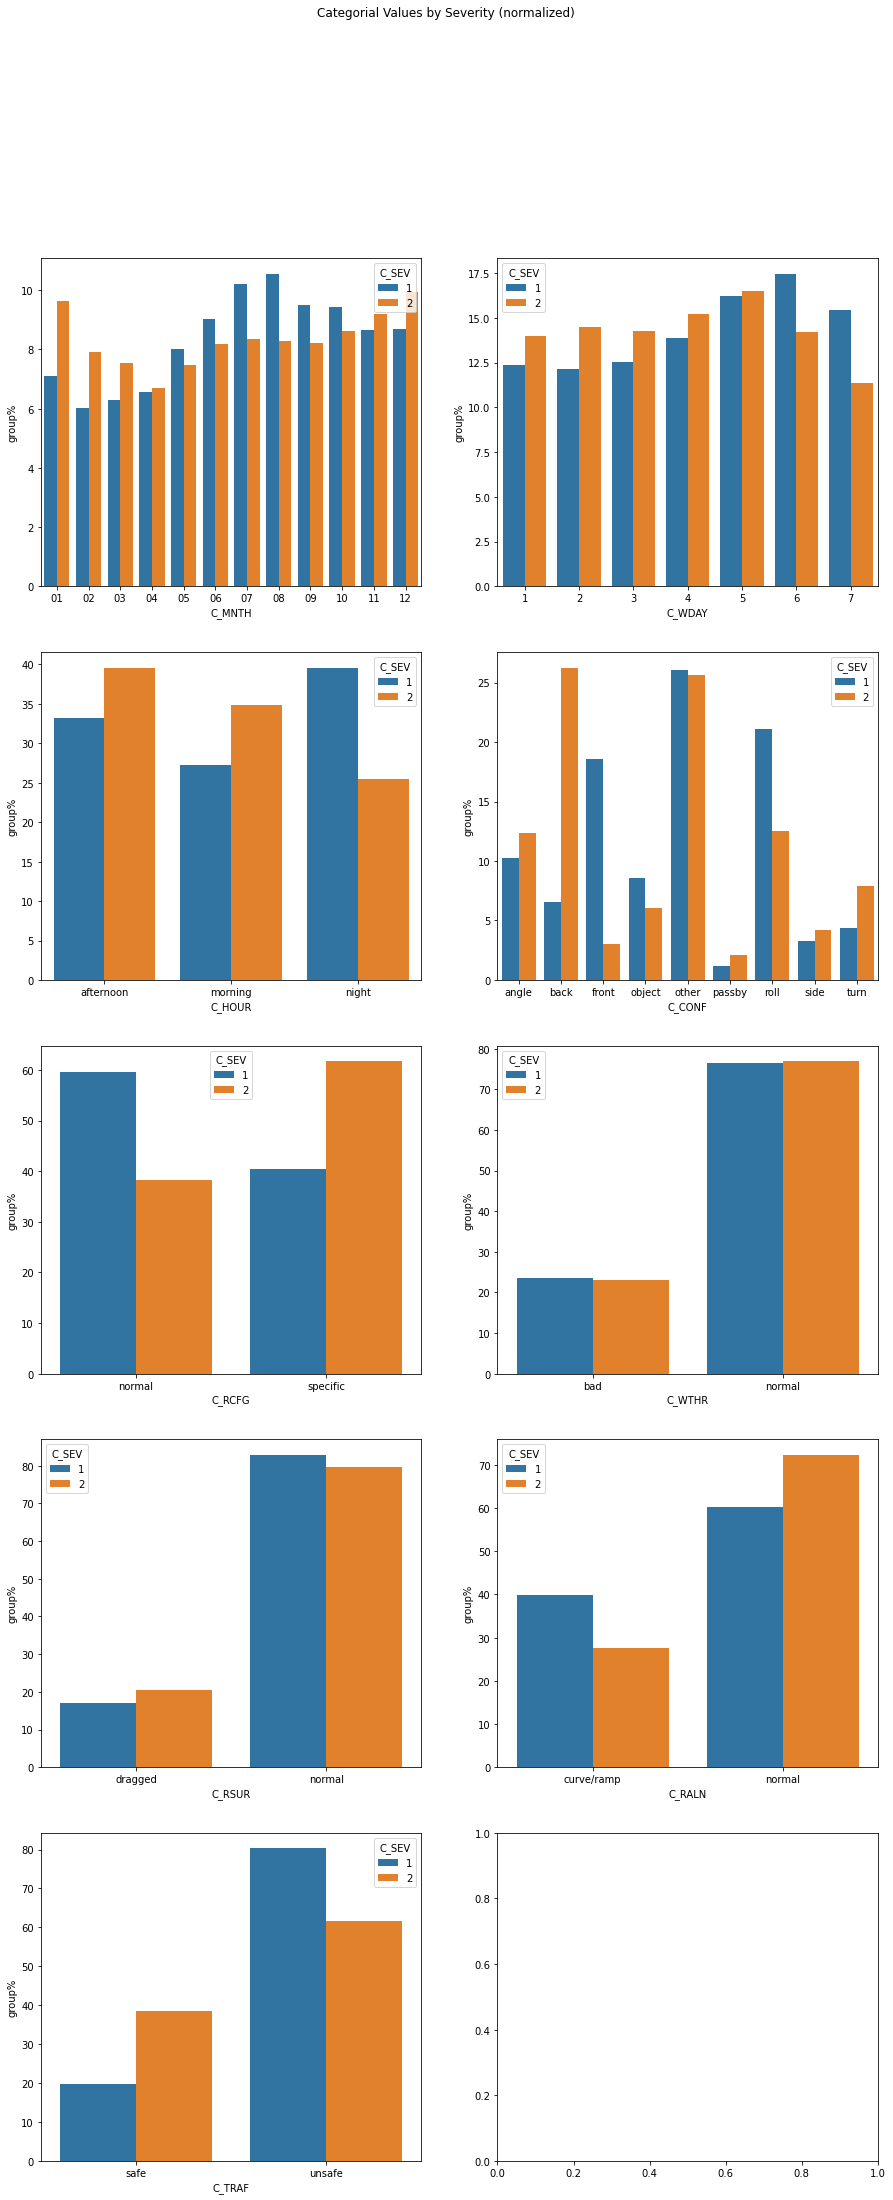

In [43]:
categorical = ['C_MNTH', 'C_WDAY', 'C_HOUR', 'C_CONF', 
               'C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN', 
               'C_TRAF']

XY_train = X_train.copy()
XY_train['C_SEV'] = Y_train

fig, axes = plt.subplots(5, 2, figsize=(15, 35), sharey=False)
fig.suptitle('Categorial Values by Severity (normalized)')

i = 0
j = 0
for cat in categorical:
    temp = eda_tools.norm_category(df = XY_train, obj_val = 'C_SEV', cat_val = cat)
    sns.barplot(data = temp, x = cat, y = 'group%', hue = 'C_SEV', ax = axes[i,j]);
    if (j == 0): 
        j = 1
    else:
        j = 0
        i += 1

Como norma general debido al elevado uso de categorías en algunas variables, se va a evitar utilizar téncicas como OneHotEncoder de manera abusiva pues crearía demasidas variables.

**Label Encoder**

Se hará uso del LabelEncoder para las variables con solo dos categorías. Estas son: ```C_RCFG```, ```C_WTHR```, ```C_RSUR```, ```C_RALN``` y ```C_TRAF```. Al tener únicamente dos categorías, resulta interesante hacer uso de 1 y 0 para poder diferenciarlas. 

Ref: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [46]:
labelCat = ['C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN', 'C_TRAF']
lb = preprocessing.LabelEncoder()

In [47]:
for cat in labelCat:
    X_train[cat] = lb.fit_transform(X_train[cat])
    X_test[cat] = lb.fit_transform(X_test[cat])

**Ordinal Encoder**

Haremos uso de un OrdinalEncoder para las variables mes y día de semana. Las razones detrás de esta elección son que observamos una concentración de los datos entorno a algunas categorias cointiguas lo que permite poder utilizar valores ordinales para poder clasificar las variables. Variables: ```C_MNTH``` y ```C_WDAY```.

Ref: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html

In [53]:
orderCat = ['C_MNTH', 'C_WDAY']
oe = preprocessing.OrdinalEncoder()

In [57]:
for cat in orderCat:
    X_train[cat] = oe.fit_transform(X_train[[cat]])
    X_test[cat] = oe.fit_transform(X_test[[cat]])

**Mean Encoder**

Para la variable ```C_CONF``` haremos uso de la técnica del MeanEncoder. Este se ha elejido debio a la variabilidad existente en esta variable y cierta aleatoriedad. Para ello este método creará una relació  entre la categoría y la variable objetivo. Su incoveniente es que puede generar overfitting por lo que solo lo usaremos una vez. 

Ref: https://towardsdatascience.com/why-you-should-try-mean-encoding-17057262cd0

Ref: https://www.geeksforgeeks.org/mean-encoding-machine-learning/

In [69]:
# Train
data={'Categories': X_train['C_CONF'],
      'Target':Y_train}
data = pd.DataFrame(data) 

Mean_encoded_subject = data.groupby(['Categories'])['Target'].mean().to_dict()
X_train['C_CONF'] =  X_train['C_CONF'].map(Mean_encoded_subject)

In [72]:
# Test
data={'Categories': X_test['C_CONF'],
      'Target':Y_test}
data = pd.DataFrame(data) 

Mean_encoded_subject = data.groupby(['Categories'])['Target'].mean().to_dict()
X_test['C_CONF'] =  X_test['C_CONF'].map(Mean_encoded_subject)

**One Hot Encoder**

Finalmente, haremos uso del OneHotEncoder para la variable ```C_HOUR```. Esta solo tiene tres categorías lo que creará solo dos variables nuevas. 

Ref: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder

In [73]:
ohe = preprocessing.OneHotEncoder()

In [100]:
# Train
categories = ohe.fit_transform(X_train[['C_HOUR']]).toarray()
new_categories = ['C_HOUR_A', 'C_HOUR_M', 'C_HOUR_N']
position = 0
for nc in new_categories:
    accum = list()
    for enc in categories:
        accum.append(enc[position])
    X_train[nc] = accum
    position += 1

X_train = X_train.drop(['C_HOUR'], axis=1)

In [102]:
# Test
categories = ohe.fit_transform(X_test[['C_HOUR']]).toarray()
new_categories = ['C_HOUR_A', 'C_HOUR_M', 'C_HOUR_N']
position = 0
for nc in new_categories:
    accum = list()
    for enc in categories:
        accum.append(enc[position])
    X_test[nc] = accum
    position += 1

X_test = X_test.drop(['C_HOUR'], axis=1)

### 3.4.4 Selección de variables

#### 3.4.4.1 Correlaciones

<AxesSubplot:>

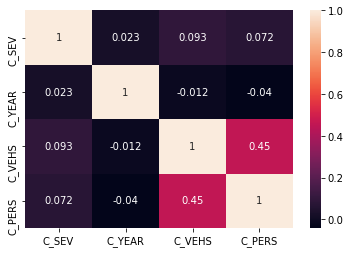

In [40]:
XY_train = X_train.copy()
XY_train['C_SEV'] = Y_train
sns.heatmap(XY_train[['C_SEV', 'C_YEAR', 'C_VEHS', 'C_PERS']].corr(), annot = True)

In [34]:
# Lasso o modelo de regresión?
# Justificar elección final ? 

## 3.5 Modelo final

---

<div style='text-align:center'>Elaborado por Álvaro Serrano del Rincón (<i>a.serranodelrincon@cunef.edu</i>)</div> 
<div style='text-align:center'>y Carlos Viñals Guitart (<i>carlos.vinals@cunef.edu</i>)</div> 